In [3]:
import gc
import glob
import os
import time
import traceback
from contextlib import contextmanager
from enum import Enum
from typing import Dict, List, Optional, Tuple

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from IPython.display import display

from joblib import delayed, Parallel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import GroupKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale
from tqdm import tqdm_notebook as tqdm


%matplotlib inline

# DATA_DIR = '../input'
DATA_DIR = '/Users/pujanmaharjan/uni adelaide/uofa_research_project/datasets'

# data configurations
USE_PRECOMPUTE_FEATURES = True  # Load precomputed features for train.csv from private dataset (just for speed up)

# model & ensemble configurations
PREDICT_CNN = True
PREDICT_MLP = True
PREDICT_GBDT = True
PREDICT_TABNET = False

GBDT_NUM_MODELS = 5 #3
GBDT_LR = 0.02  # 0.1

NN_VALID_TH = 0.185
NN_MODEL_TOP_N = 3
TAB_MODEL_TOP_N = 3
ENSEMBLE_METHOD = 'mean'
NN_NUM_MODELS = 10
TABNET_NUM_MODELS = 5

# for saving quota
IS_1ST_STAGE = False
SHORTCUT_NN_IN_1ST_STAGE = False  # early-stop training to save GPU quota
SHORTCUT_GBDT_IN_1ST_STAGE = False
MEMORY_TEST_MODE = False

# for ablation studies
CV_SPLIT = 'time'  # 'time': time-series KFold 'group': GroupKFold by stock-id
USE_PRICE_NN_FEATURES = True  # Use nearest neighbor features that rely on tick size
USE_VOL_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_SIZE_NN_FEATURES = True  # Use nearest neighbor features that can be calculated without tick size
USE_RANDOM_NN_FEATURES = False  # Use random index to aggregate neighbors

USE_TIME_ID_NN = True  # Use time-id based neighbors
USE_STOCK_ID_NN = True  # Use stock-id based neighbors

ENABLE_RANK_NORMALIZATION = True  # Enable rank-normalization


@contextmanager
def timer(name: str):
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f'[{name}] {elapsed: .3f}sec')
    
def print_trace(name: str = ''):
    print(f'ERROR RAISED IN {name or "anonymous"}')
    print(traceback.format_exc())

In [ ]:
# !pip -q install ../input/pytorchtabnet/pytorch_tabnet-2.0.1-py3-none-any.whl

In [4]:
train = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'train.csv'))
stock_ids = set(train['stock_id'])

## Feature Engineering

### Base Features

In [5]:
class DataBlock(Enum):
    TRAIN = 1
    TEST = 2
    BOTH = 3


def load_stock_data(stock_id: int, directory: str) -> pd.DataFrame:
    return pd.read_parquet(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', directory, f'stock_id={stock_id}'))


def load_data(stock_id: int, stem: str, block: DataBlock) -> pd.DataFrame:
    if block == DataBlock.TRAIN:
        return load_stock_data(stock_id, f'{stem}_train.parquet')
    elif block == DataBlock.TEST:
        return load_stock_data(stock_id, f'{stem}_test.parquet')
    else:
        return pd.concat([
            load_data(stock_id, stem, DataBlock.TRAIN),
            load_data(stock_id, stem, DataBlock.TEST)
        ]).reset_index(drop=True)

def load_book(stock_id: int, block: DataBlock=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'book', block)


def load_trade(stock_id: int, block=DataBlock.TRAIN) -> pd.DataFrame:
    return load_data(stock_id, 'trade', block)


def calc_wap1(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap


def calc_wap2(df: pd.DataFrame) -> pd.Series:
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap


def realized_volatility(series):
    return np.sqrt(np.sum(series**2))


def log_return(series: np.ndarray):
    return np.log(series).diff()


def log_return_df2(series: np.ndarray):
    return np.log(series).diff(2)


def flatten_name(prefix, src_names):
    ret = []
    for c in src_names:
        if c[0] in ['time_id', 'stock_id']:
            ret.append(c[0])
        else:
            ret.append('.'.join([prefix] + list(c)))
    return ret


def make_book_feature(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    book['wap1'] = calc_wap1(book)
    book['wap2'] = calc_wap2(book)
    book['log_return1'] = book.groupby(['time_id'])['wap1'].apply(log_return)
    book['log_return2'] = book.groupby(['time_id'])['wap2'].apply(log_return)
    book['log_return_ask1'] = book.groupby(['time_id'])['ask_price1'].apply(log_return)
    book['log_return_ask2'] = book.groupby(['time_id'])['ask_price2'].apply(log_return)
    book['log_return_bid1'] = book.groupby(['time_id'])['bid_price1'].apply(log_return)
    book['log_return_bid2'] = book.groupby(['time_id'])['bid_price2'].apply(log_return)

    book['wap_balance'] = abs(book['wap1'] - book['wap2'])
    book['price_spread'] = (book['ask_price1'] - book['bid_price1']) / ((book['ask_price1'] + book['bid_price1']) / 2)
    book['bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['total_volume'] = (book['ask_size1'] + book['ask_size2']) + (book['bid_size1'] + book['bid_size2'])
    book['volume_imbalance'] = abs((book['ask_size1'] + book['ask_size2']) - (book['bid_size1'] + book['bid_size2']))
    
    features = {
        'seconds_in_bucket': ['count'],
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_ask2': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return_bid2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std]
    }
    
    agg = book.groupby('time_id').agg(features).reset_index(drop=False)
    agg.columns = flatten_name('book', agg.columns)
    agg['stock_id'] = stock_id
    
    for time in [450, 300, 150]:
        d = book[book['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'book_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg


def make_trade_feature(stock_id, block = DataBlock.TRAIN):
    trade = load_trade(stock_id, block)
    trade['log_return'] = trade.groupby('time_id')['price'].apply(log_return)

    features = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':['count'],
        'size':[np.sum],
        'order_count':[np.mean],
    }

    agg = trade.groupby('time_id').agg(features).reset_index()
    agg.columns = flatten_name('trade', agg.columns)
    agg['stock_id'] = stock_id
        
    for time in [450, 300, 150]:
        d = trade[trade['seconds_in_bucket'] >= time].groupby('time_id').agg(features).reset_index(drop=False)
        d.columns = flatten_name(f'trade_{time}', d.columns)
        agg = pd.merge(agg, d, on='time_id', how='left')
    return agg


def make_book_feature_v2(stock_id, block = DataBlock.TRAIN):
    book = load_book(stock_id, block)

    prices = book.set_index('time_id')[['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']]
    time_ids = list(set(prices.index))

    ticks = {}
    for tid in time_ids:
        try:
            price_list = prices.loc[tid].values.flatten()
            price_diff = sorted(np.diff(sorted(set(price_list))))
            ticks[tid] = price_diff[0]
        except Exception:
            print_trace(f'tid={tid}')
            ticks[tid] = np.nan
        
    dst = pd.DataFrame()
    dst['time_id'] = np.unique(book['time_id'])
    dst['stock_id'] = stock_id
    dst['tick_size'] = dst['time_id'].map(ticks)

    return dst


def make_features(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature)(i, block) for i in stock_ids)
        book = pd.concat(books)

    with timer('trades'):
        trades = Parallel(n_jobs=-1)(delayed(make_trade_feature)(i, block) for i in stock_ids)
        trade = pd.concat(trades)

    with timer('extra features'):
        df = pd.merge(base, book, on=['stock_id', 'time_id'], how='left')
        df = pd.merge(df, trade, on=['stock_id', 'time_id'], how='left')
        #df = make_extra_features(df)

    return df


def make_features_v2(base, block):
    stock_ids = set(base['stock_id'])
    with timer('books(v2)'):
        books = Parallel(n_jobs=-1)(delayed(make_book_feature_v2)(i, block) for i in stock_ids)
        book_v2 = pd.concat(books)

    d = pd.merge(base, book_v2, on=['stock_id', 'time_id'], how='left')
    return d

In [7]:
USE_PRECOMPUTE_FEATURES=True
if USE_PRECOMPUTE_FEATURES:
    with timer('load feather'):
        df = pd.read_feather(os.path.join(DATA_DIR, 'optiver-df2', 'features_v2.f'))
else:
    df = make_features(train, DataBlock.TRAIN)
    # v2
    df = make_features_v2(df, DataBlock.TRAIN)

df.to_feather('features_v2.f')  # save cache

test = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'test.csv'))
if len(test) == 3:
    print('is 1st stage')
    IS_1ST_STAGE = True

if IS_1ST_STAGE and MEMORY_TEST_MODE:
    print('use copy of training data as test data to immitate 2nd stage RAM usage.')
    test_df = df.iloc[:170000].copy()
    test_df['time_id'] += 32767
    test_df['row_id'] = ''
else:
    test_df = make_features(test, DataBlock.TEST)
    test_df = make_features_v2(test_df, DataBlock.TEST)

print(df.shape)
print(test_df.shape)
df = pd.concat([df, test_df.drop('row_id', axis=1)]).reset_index(drop=True)

/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1457280217.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1457280217.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m00

[books]  399.604sec


/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1457280217.py:112: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1457280217.py:112: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m

[trades]  41.873sec
[extra features]  5.300sec
[books(v2)]  32.192sec
is 1st stage
[books]  0.134sec
[trades]  0.051sec
[extra features]  0.005sec
[books(v2)]  0.007sec
(428932, 216)
(3, 216)


/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1457280217.py:67: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1457280217.py:68: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m00

### Nearest-Neighbor Features

In [8]:
N_NEIGHBORS_MAX = 80

class Neighbors:
    def __init__(self, 
                 name: str, 
                 pivot: pd.DataFrame, 
                 p: float, 
                 metric: str = 'minkowski', 
                 metric_params: Optional[Dict] = None, 
                 exclude_self: bool = False):
        self.name = name
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric
        
        if metric == 'random':
            n_queries = len(pivot)
            self.neighbors = np.random.randint(n_queries, size=(n_queries, N_NEIGHBORS_MAX))
        else:
            nn = NearestNeighbors(
                n_neighbors=N_NEIGHBORS_MAX, 
                p=p, 
                metric=metric, 
                metric_params=metric_params
            )
            nn.fit(pivot)
            _, self.neighbors = nn.kneighbors(pivot, return_distance=True)

        self.columns = self.index = self.feature_values = self.feature_col = None

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        raise NotImplementedError()

    def make_nn_feature(self, n=5, agg=np.mean) -> pd.DataFrame:
        assert self.feature_values is not None, "should call rearrange_feature_values beforehand"

        start = 1 if self.exclude_self else 0

        pivot_aggs = pd.DataFrame(
            agg(self.feature_values[start:n,:,:], axis=0), 
            columns=self.columns, 
            index=self.index
        )

        dst = pivot_aggs.unstack().reset_index()
        dst.columns = ['stock_id', 'time_id', f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}']
        return dst


class TimeIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())
        feature_pivot.head()

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[self.neighbors[:, i], :]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col
        
    def __repr__(self) -> str:
        return f"time-id NN (name={self.name}, metric={self.metric}, p={self.p})"


class StockIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        """stock-id based nearest neighbor features"""
        feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
        feature_pivot = feature_pivot.fillna(feature_pivot.mean())

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[:, self.neighbors[:, i]]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col
        
    def __repr__(self) -> str:
        return f"stock-id NN (name={self.name}, metric={self.metric}, p={self.p})"


In [9]:
# the tau itself is meaningless for GBDT, but useful as input to aggregate in Nearest Neighbor features
df['trade.tau'] = np.sqrt(1 / df['trade.seconds_in_bucket.count'])
df['trade_150.tau'] = np.sqrt(1 / df['trade_150.seconds_in_bucket.count'])
df['book.tau'] = np.sqrt(1 / df['book.seconds_in_bucket.count'])
df['real_price'] = 0.01 / df['tick_size']

#### Build Nearest Neighbors

In [11]:
time_id_neighbors: List[Neighbors] = []
stock_id_neighbors: List[Neighbors] = []

with timer('knn fit'):
    df_pv = df[['stock_id', 'time_id']].copy()
    df_pv['price'] = 0.01 / df['tick_size']
    df_pv['vol'] = df['book.log_return1.realized_volatility']
    df_pv['trade.tau'] = df['trade.tau']
    df_pv['trade.size.sum'] = df['book.total_volume.sum']

    if USE_PRICE_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'price')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_c', 
                pivot, 
                p=2, 
                metric='canberra', 
                exclude_self=True
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_m', 
                pivot, 
                p=2, 
                metric='mahalanobis',
                # metric_params={'V':np.cov(pivot.values.T)}
                metric_params={'VI':np.linalg.inv(np.cov(pivot.values.T))}
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_price_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True)
        )

    if USE_VOL_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors('time_vol_l1', pivot, p=1)
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_vol_l1', 
                minmax_scale(pivot.transpose()), 
                p=1, 
                exclude_self=True
            )
        )

    if USE_SIZE_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'trade.size.sum')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_m', 
                pivot, 
                p=2, 
                metric='mahalanobis', 
                # metric_params={'V':np.cov(pivot.values.T)}
                metric_params={'VI':np.linalg.inv(np.cov(pivot.values.T))}
            )
        )
        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_size_c', 
                pivot, 
                p=2, 
                metric='canberra'
            )
        )
        
    if USE_RANDOM_NN_FEATURES:
        pivot = df_pv.pivot('time_id', 'stock_id', 'vol')
        pivot = pivot.fillna(pivot.mean())
        pivot = pd.DataFrame(minmax_scale(pivot))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_random', 
                pivot, 
                p=2, 
                metric='random'
            )
        )
        stock_id_neighbors.append(
            StockIdNeighbors(
                'stock_random', 
                pivot.transpose(), 
                p=2,
                metric='random')
        )


if not USE_TIME_ID_NN:
    time_id_neighbors = []
    
if not USE_STOCK_ID_NN:
    stock_id_neighbors = []

/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/2981972214.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot = df_pv.pivot('time_id', 'stock_id', 'price')
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/2981972214.py:44: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot = df_pv.pivot('time_id', 'stock_id', 'vol')
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/2981972214.py:61: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot = df_pv.pivot('time_id', 'stock_id', 'trade.size.sum')


[knn fit]  247.481sec


#### Check Neighbor Indices

In [12]:
def calculate_rank_correraltion(neighbors, top_n=5):
    if not neighbors:
        return
    neighbor_indices = pd.DataFrame()
    for n in neighbors:
        neighbor_indices[n.name] = n.neighbors[:,:top_n].flatten()

    sns.heatmap(neighbor_indices.corr('kendall'), annot=True)

In [13]:
time_ids = np.array(sorted(df['time_id'].unique()))
for neighbor in time_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).iloc[1:6]
    )

time-id NN (name=time_price_c, metric=canberra, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,30183,31471,26708,7864,22752,10619,11453,1205,9352
11,11,2811,29583,30798,17639,25131,23202,14857,4739,3399
16,16,5829,4275,7783,4487,7845,25439,17530,18634,19747
31,31,6367,19386,1255,12559,19472,18358,31719,6481,26475
32,34,32,4,31554,24443,5916,19164,20430,659,31077


time-id NN (name=time_price_m, metric=mahalanobis, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,30183,31471,26708,1205,22752,10619,9352,7864,11453
11,11,2811,29583,30798,17639,23202,25131,14857,4739,28020
16,16,5829,4487,7783,25439,17530,7845,4275,32590,18634
31,31,6367,19386,12559,1255,22519,19472,31719,6481,18358
32,32,34,4,19230,17460,4913,14311,20597,20935,3046


time-id NN (name=time_vol_l1, metric=minkowski, p=1)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,9352,15276,13791,1205,12923,26708,2331,2136,10672
11,11,23202,30798,17639,7460,29583,11227,2811,25131,32597
16,16,9060,25179,25439,21777,15727,17530,6476,211,30791
31,31,10291,15689,18848,22824,14449,1142,6367,21148,25731
32,32,34,4,25584,26883,5235,2772,26430,2502,22014


time-id NN (name=time_size_m, metric=mahalanobis, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,26708,22752,30183,34,32,9352,27014,1205,4
11,11,29583,2811,14857,17639,32,34,11682,13513,4739
16,16,15352,5829,13775,11869,10364,15491,1797,7783,32
31,31,6367,31719,32,34,18358,12559,19472,22519,31522
32,32,34,4,31004,16649,1161,611,13586,23967,20410


time-id NN (name=time_size_c, metric=canberra, p=2)


,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
time_id,,,,,,,,,,
5,5,26708,30183,22752,1205,10619,9352,15276,30620,2683
11,11,2811,17639,29583,25131,28020,17604,9822,4739,30798
16,16,5829,4487,6121,7783,1040,29026,7845,17530,16118
31,31,6367,12559,22519,18358,7897,19472,31522,19386,31719
32,32,34,4,15989,11985,3732,26430,3607,10523,4487


In [14]:
stock_ids = np.array(sorted(df['stock_id'].unique()))
for neighbor in stock_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            stock_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(stock_ids, name='stock_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).loc[64]
    )
    

stock-id NN (name=stock_price_l1, metric=minkowski, p=1)


top_1      64
top_2      53
top_3      56
top_4     124
top_5      73
top_6      96
top_7      30
top_8      28
top_9      66
top_10     33
Name: 64, dtype: int64

stock-id NN (name=stock_vol_l1, metric=minkowski, p=1)


top_1      64
top_2      20
top_3      93
top_4      67
top_5      52
top_6     107
top_7      70
top_8     120
top_9     102
top_10     39
Name: 64, dtype: int64

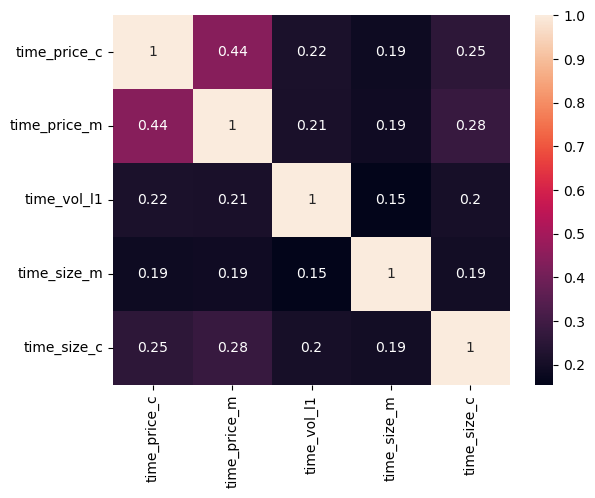

In [15]:
calculate_rank_correraltion(time_id_neighbors)

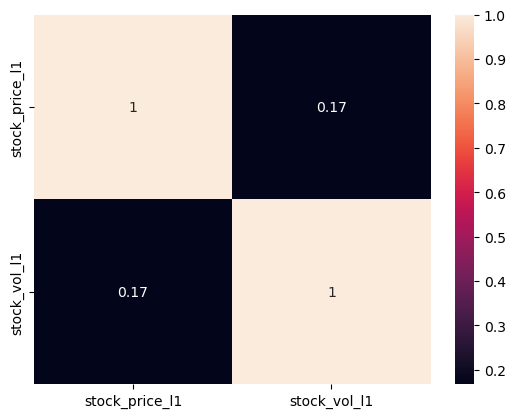

In [16]:
calculate_rank_correraltion(stock_id_neighbors)

#### Aggregate Features With Neighbors

In [17]:
# features with large changes over time are converted to relative ranks within time-id
if ENABLE_RANK_NORMALIZATION:
    df['trade.order_count.mean'] = df.groupby('time_id')['trade.order_count.mean'].rank()
    df['book.total_volume.sum']  = df.groupby('time_id')['book.total_volume.sum'].rank()
    df['book.total_volume.mean'] = df.groupby('time_id')['book.total_volume.mean'].rank()
    df['book.total_volume.std']  = df.groupby('time_id')['book.total_volume.std'].rank()

    df['trade.tau'] = df.groupby('time_id')['trade.tau'].rank()

    for dt in [150, 300, 450]:
        df[f'book_{dt}.total_volume.sum']  = df.groupby('time_id')[f'book_{dt}.total_volume.sum'].rank()
        df[f'book_{dt}.total_volume.mean'] = df.groupby('time_id')[f'book_{dt}.total_volume.mean'].rank()
        df[f'book_{dt}.total_volume.std']  = df.groupby('time_id')[f'book_{dt}.total_volume.std'].rank()
        df[f'trade_{dt}.order_count.mean'] = df.groupby('time_id')[f'trade_{dt}.order_count.mean'].rank()

In [18]:
def make_nearest_neighbor_feature(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()
    print(df2.shape)

    feature_cols_stock = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade_150.tau': [np.mean],
        'book.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
    }
    
    feature_cols = {
        'book.log_return1.realized_volatility': [np.mean, np.min, np.max, np.std],
        'real_price': [np.max, np.mean, np.min],
        'trade.seconds_in_bucket.count': [np.mean],
        'trade.tau': [np.mean],
        'trade.size.sum': [np.mean],
        'book.seconds_in_bucket.count': [np.mean],
        'trade_150.tau_nn20_stock_vol_l1_mean': [np.mean],
        'trade.size.sum_nn20_stock_vol_l1_mean': [np.mean],
    }

    time_id_neigbor_sizes = [3, 5, 10, 20, 40]
    time_id_neigbor_sizes_vol = [2, 3, 5, 10, 20, 40]
    stock_id_neighbor_sizes = [10, 20, 40]

    ndf: Optional[pd.DataFrame] = None

    def _add_ndf(ndf: Optional[pd.DataFrame], dst: pd.DataFrame) -> pd.DataFrame:
        if ndf is None:
            return dst
        else:
            ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
            return ndf

    # neighbor stock_id
    for feature_col in feature_cols_stock.keys():
        try:
            if feature_col not in df2.columns:
                print(f"column {feature_col} is skipped")
                continue

            if not stock_id_neighbors:
                continue

            for nn in stock_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            for agg in feature_cols_stock[feature_col]:
                for n in stock_id_neighbor_sizes:
                    try:
                        for nn in stock_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            ndf = _add_ndf(ndf, dst)
                    except Exception:
                        print_trace('stock-id nn')
                        pass
        except Exception:
            print_trace('stock-id nn')
            pass

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')
    ndf = None

    print(df2.shape)

    # neighbor time_id
    for feature_col in feature_cols.keys():
        try:
            if not USE_PRICE_NN_FEATURES and feature_col == 'real_price':
                continue
            if feature_col not in df2.columns:
                print(f"column {feature_col} is skipped")
                continue

            for nn in time_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            if 'volatility' in feature_col:
                time_id_ns = time_id_neigbor_sizes_vol
            else:
                time_id_ns = time_id_neigbor_sizes

            for agg in feature_cols[feature_col]:
                for n in time_id_ns:
                    try:
                        for nn in time_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            ndf = _add_ndf(ndf, dst)
                    except Exception:
                        print_trace('time-id nn')
                        pass
        except Exception:
            print_trace('time-id nn')

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id', 'stock_id'], how='left')

    # features further derived from nearest neighbor features
    try:
        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neigbor_sizes:
                denominator = f"real_price_nn{sz}_time_price_c"

                df2[f'real_price_rankmin_{sz}']  = df2['real_price'] / df2[f"{denominator}_amin"]
                df2[f'real_price_rankmax_{sz}']  = df2['real_price'] / df2[f"{denominator}_amax"]
                df2[f'real_price_rankmean_{sz}'] = df2['real_price'] / df2[f"{denominator}_mean"]

            for sz in time_id_neigbor_sizes_vol:
                denominator = f"book.log_return1.realized_volatility_nn{sz}_time_price_c"

                df2[f'vol_rankmin_{sz}'] = \
                    df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_amin"]
                df2[f'vol_rankmax_{sz}'] = \
                    df2['book.log_return1.realized_volatility'] / df2[f"{denominator}_amax"]

        price_cols = [c for c in df2.columns if 'real_price' in c and 'rank' not in c]
        for c in price_cols:
            del df2[c]

        if USE_PRICE_NN_FEATURES:
            for sz in time_id_neigbor_sizes_vol:
                tgt = f'book.log_return1.realized_volatility_nn{sz}_time_price_m_mean'
                df2[f'{tgt}_rank'] = df2.groupby('time_id')[tgt].rank()
    except Exception:
        print_trace('nn features')

    return df2

In [19]:
gc.collect()

with timer('make nearest neighbor feature'):
    df2 = make_nearest_neighbor_feature(df)

print(df2.shape)
df2.reset_index(drop=True).to_feather('optiver_df2.f')

gc.collect()

(428935, 220)


/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1586917157.py:73: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1586917157.py:73: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1586917157.py:73: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1586917157.py:73: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
/var/folders/pp/

(428935, 280)


/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1586917157.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1586917157.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1586917157.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/1586917157.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  feature_pivot = df.pivot('time_id', 'stock_id', feature_col)
/var/folders/pp/

[make nearest neighbor feature]  68.994sec
(428935, 582)


0

### Misc Features

In [20]:
# skew correction for NN
cols_to_log = [
    'trade.size.sum',
    'trade_150.size.sum',
    'trade_300.size.sum',
    'trade_450.size.sum',
    'volume_imbalance'
]
for c in df2.columns:
    for check in cols_to_log:
        try:
            if check in c:
                df2[c] = np.log(df2[c]+1)
                break
        except Exception:
            print_trace('log1p')

In [21]:
# Rolling average of RV for similar trading volume
try:
    df2.sort_values(by=['stock_id', 'book.total_volume.sum'], inplace=True)
    df2.reset_index(drop=True, inplace=True)
    
    roll_target = 'book.log_return1.realized_volatility'

    for window_size in [3, 10]:
        df2[f'realized_volatility_roll{window_size}_by_book.total_volume.mean'] = \
            df2.groupby('stock_id')[roll_target].rolling(window_size, center=True, min_periods=1) \
                                                .mean() \
                                                .reset_index() \
                                                .sort_values(by=['level_1'])[roll_target].values
except Exception:
    print_trace('mean RV')

/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/2475865050.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'realized_volatility_roll{window_size}_by_book.total_volume.mean'] = \
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/2475865050.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'realized_volatility_roll{window_size}_by_book.total_volume.mean'] = \


In [22]:
# stock-id embedding (helps little)
try:
    lda_n = 3
    lda = LatentDirichletAllocation(n_components=lda_n, random_state=0)

    stock_id_emb = pd.DataFrame(
        lda.fit_transform(pivot.transpose()), 
        index=df_pv.pivot('time_id', 'stock_id', 'vol').columns
    )

    for i in range(lda_n):
        df2[f'stock_id_emb{i}'] = df2['stock_id'].map(stock_id_emb[i])
except Exception:
    print_trace('LDA')

/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/342520599.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  index=df_pv.pivot('time_id', 'stock_id', 'vol').columns
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/342520599.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'stock_id_emb{i}'] = df2['stock_id'].map(stock_id_emb[i])
/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/342520599.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `new

In [23]:
df_train = df2[~df2.target.isnull()].copy()
df_test = df2[df2.target.isnull()].copy()
del df2, df_pv
gc.collect()

0

## Reverse Engineering time-id Order & Make CV Split

In [25]:
%matplotlib inline

@contextmanager
def timer(name):
    s = time.time()
    yield
    e = time.time() - s
    print(f"[{name}] {e:.3f}sec")
    

def calc_price2(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.set_index('time_id')
    df = df.groupby(level='time_id').apply(calc_price2).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


def sort_manifold(df, clf):
    df_ = df.set_index('time_id')
    df_ = pd.DataFrame(minmax_scale(df_.fillna(df_.mean())))

    X_compoents = clf.fit_transform(df_)

    dft = df.reindex(np.argsort(X_compoents[:,0])).reset_index(drop=True)
    return np.argsort(X_compoents[:, 0]), X_compoents


def reconstruct_time_id_order():
    with timer('load files'):
        df_files = pd.DataFrame(
            {'book_path': glob.glob(DATA_DIR + '/optiver-realized-volatility-prediction/book_train.parquet/**/*.parquet')}) \
            .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")', engine='python')

    with timer('calc prices'):
        df_prices = pd.concat(Parallel(n_jobs=4, verbose=51)(delayed(calc_prices)(r) for _, r in df_files.iterrows()))
        df_prices = df_prices.pivot('time_id', 'stock_id', 'price')
        df_prices.columns = [f'stock_id={i}' for i in df_prices.columns]
        df_prices = df_prices.reset_index(drop=False)

    with timer('t-SNE(400) -> 50'):
        clf = TSNE(n_components=1, perplexity=400, random_state=0, n_iter=2000)
        order, X_compoents = sort_manifold(df_prices, clf)

        clf = TSNE(n_components=1, perplexity=50, random_state=0, init=X_compoents, n_iter=2000, method='exact')
        order, X_compoents = sort_manifold(df_prices, clf)

        df_ordered = df_prices.reindex(order).reset_index(drop=True)
        if df_ordered['stock_id=61'].iloc[0] > df_ordered['stock_id=61'].iloc[-1]:
            df_ordered = df_ordered.reindex(df_ordered.index[::-1]).reset_index(drop=True)

    # AMZN
    plt.plot(df_ordered['stock_id=61'])
    
    return df_ordered[['time_id']]

[load files] 0.135sec
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done  15 tasks      | elaps

/var/folders/pp/_bf_mjdj79z56mjy09xcbd6m0000gn/T/ipykernel_22057/2020496493.py:42: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_prices = df_prices.pivot('time_id', 'stock_id', 'price')


[calc prices] 27.297sec
[t-SNE(400) -> 50] 303.162sec
[calculate order of time-id] 330.869sec
folds0: train=257362, valid=42882
folds1: train=300244, valid=42896
folds2: train=343140, valid=42896
folds3: train=386036, valid=42896
[make folds] 15.541sec


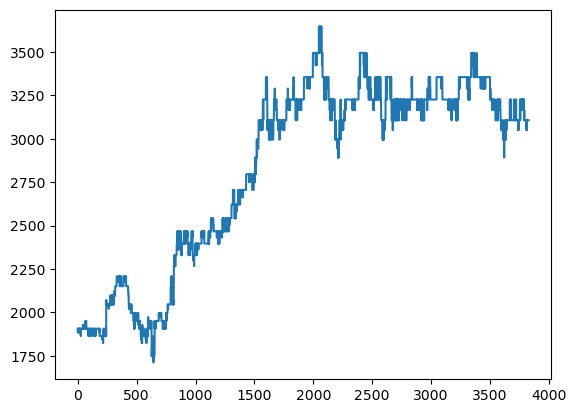

In [26]:
if CV_SPLIT == 'time':
    with timer('calculate order of time-id'):
        if USE_PRECOMPUTE_FEATURES:
            timeid_order = pd.read_csv(os.path.join(DATA_DIR, 'optiver-time-id-ordered', 'time_id_order.csv'))
        else:
            timeid_order = reconstruct_time_id_order()

    with timer('make folds'):
        timeid_order['time_id_order'] = np.arange(len(timeid_order))
        df_train['time_id_order'] = df_train['time_id'].map(timeid_order.set_index('time_id')['time_id_order'])
        df_train = df_train.sort_values(['time_id_order', 'stock_id']).reset_index(drop=True)

        folds_border = [3830 - 383*4, 3830 - 383*3, 3830 - 383*2, 3830 - 383*1]
        time_id_orders = df_train['time_id_order']

        folds = []
        for i, border in enumerate(folds_border):
            idx_train = np.where(time_id_orders < border)[0]
            idx_valid = np.where((border <= time_id_orders) & (time_id_orders < border + 383))[0]
            folds.append((idx_train, idx_valid))

            print(f"folds{i}: train={len(idx_train)}, valid={len(idx_valid)}")

    del df_train['time_id_order']
elif CV_SPLIT == 'group':
    gkf = GroupKFold(n_splits=4)
    folds = []

    for i, (idx_train, idx_valid) in enumerate(gkf.split(df_train, None, groups=df_train['time_id'])):
        folds.append((idx_train, idx_valid))
else:
    raise ValueError()

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

## LightGBM Training

In [27]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False


# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(cvbooster, figsize=(10, 10)):
    raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = cvbooster.boosters[0].feature_name()
    importance_df = pd.DataFrame(data=raw_importances,
                                 columns=feature_name)
    # order by average importance across folds
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # plot top-n
    PLOT_TOP_N = 50
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()


def get_X(df_src):
    cols = [c for c in df_src.columns if c not in ['time_id', 'target', 'tick_size']]
    return df_src[cols]


class EnsembleModel:
    def __init__(self, models: List[lgb.Booster], weights: Optional[List[float]] = None):
        self.models = models
        self.weights = weights

        features = list(self.models[0].feature_name())

        for m in self.models[1:]:
            assert features == list(m.feature_name())

    def predict(self, x):
        predicted = np.zeros((len(x), len(self.models)))

        for i, m in enumerate(self.models):
            w = self.weights[i] if self.weights is not None else 1
            predicted[:, i] = w * m.predict(x)

        ttl = np.sum(self.weights) if self.weights is not None else len(self.models)
        return np.sum(predicted, axis=1) / ttl

    def feature_name(self) -> List[str]:
        return self.models[0].feature_name()

setting lr to 0.3 for lightgbm
(428932, 584)


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.444395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.676812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.567290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	cv_agg's l2: 2.09758e-07 + 2.70539e-08	cv_agg's RMSPE: 0.204502 + 0.011272
[40]	cv_agg's l2: 2.09694e-07 + 2.78873e-08	cv_agg's RMSPE: 0.204412 + 0.011145
# overall RMSPE: 0.204315
[lgb.cv] 170.041sec
# fold0 RMSPE: 0.20831698512986205
# fold1 RMSPE: 0.2133023803191449
# fold2 RMSPE: 0.21043673935353008
# fold3 RMSPE: 0.18520182843451885


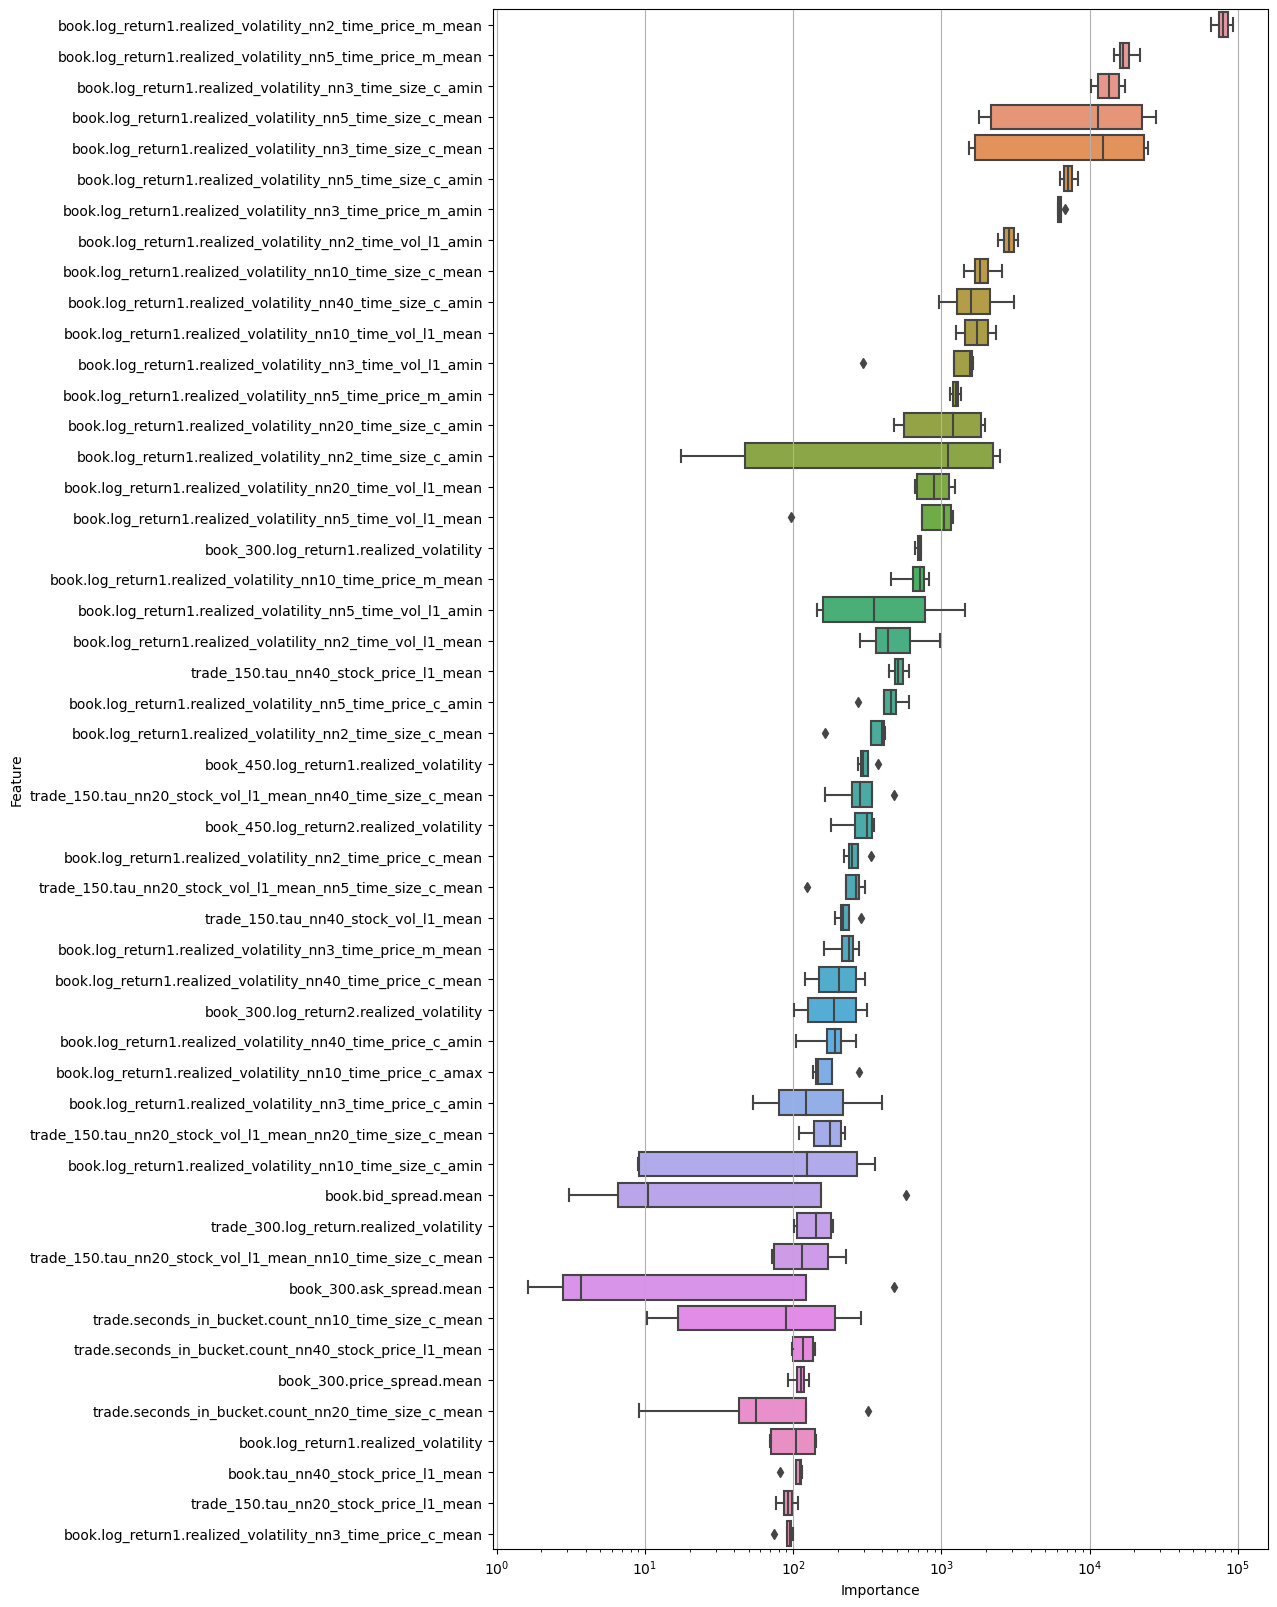

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.323964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.704085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.635790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.682576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.609139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[retraining] 43.354sec


41649

In [28]:
lr = GBDT_LR
SHORTCUT_GBDT_IN_1ST_STAGE=True
if SHORTCUT_GBDT_IN_1ST_STAGE and IS_1ST_STAGE:
    # to save GPU quota
    print('setting lr to 0.3 for lightgbm')
    lr = 0.3

params = {
    'objective': 'regression',
    'verbose': 0,
    'metric': '',
    'reg_alpha': 5,
    'reg_lambda': 5,
    'min_data_in_leaf': 1000,
    'max_depth': -1,
    'num_leaves': 128,
    'colsample_bytree': 0.3,
    'learning_rate': lr
}

X = get_X(df_train)
y = df_train['target']
X.to_feather('X.f')
df_train[['target']].to_feather('y.f')

gc.collect()

print(X.shape)

if PREDICT_GBDT:
    ds = lgb.Dataset(X, y, weight=1/np.power(y, 2))

    with timer('lgb.cv'):
        ret = lgb.cv(params, ds, num_boost_round=8000, folds=folds, #cv,
                     feval=feval_RMSPE, stratified=False, 
                     return_cvbooster=True, verbose_eval=20,
                     early_stopping_rounds=int(40*0.1/lr))

        print(f"# overall RMSPE: {ret['RMSPE-mean'][-1]}")

    best_iteration = len(ret['RMSPE-mean'])
    for i in range(len(folds)):
        y_pred = ret['cvbooster'].boosters[i].predict(X.iloc[folds[i][1]], num_iteration=best_iteration)
        y_true = y.iloc[folds[i][1]]
        print(f"# fold{i} RMSPE: {rmspe(y_true, y_pred)}")
        
        if i == len(folds) - 1:
            np.save('pred_gbdt.npy', y_pred)

    plot_importance(ret['cvbooster'], figsize=(10, 20))

    boosters = []
    with timer('retraining'):
        for i in range(GBDT_NUM_MODELS):
            params['seed'] = i
            boosters.append(lgb.train(params, ds, num_boost_round=int(1.1*best_iteration)))

    booster = EnsembleModel(boosters)
    del ret
    del ds

gc.collect()

## NN Training

In [34]:
import gc
import os
import random
from typing import List, Tuple, Optional, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


null_check_cols = [
    'book.log_return1.realized_volatility',
    'book_150.log_return1.realized_volatility',
    'book_300.log_return1.realized_volatility',
    'book_450.log_return1.realized_volatility',
    'trade.log_return.realized_volatility',
    'trade_150.log_return.realized_volatility',
    'trade_300.log_return.realized_volatility',
    'trade_450.log_return.realized_volatility'
]

NUM_WORKERS = 0

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def rmspe_metric(y_true, y_pred):
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return rmspe


def rmspe_loss(y_true, y_pred):
    rmspe = torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))
    return rmspe


class RMSPE(Metric):
    def __init__(self):
        self._name = "rmspe"
        self._maximize = False

    def __call__(self, y_true, y_score):
        return np.sqrt(np.mean(np.square((y_true - y_score) / y_true)))

def RMSPELoss_Tabnet(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class TabularDataset(Dataset):
    def __init__(self, x_num: np.ndarray, x_cat: np.ndarray, y: Optional[np.ndarray]):
        super().__init__()
        self.x_num = x_num
        self.x_cat = x_cat
        self.y = y

    def __len__(self):
        return len(self.x_num)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx])
        else:
            return self.x_num[idx], torch.LongTensor(self.x_cat[idx]), self.y[idx]


class MLP(nn.Module):
    def __init__(self,
                 src_num_dim: int,
                 n_categories: List[int],
                 dropout: float = 0.0,
                 hidden: int = 50,
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 bn: bool = False):
        super().__init__()

        self.embs = nn.ModuleList([
            nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

        if bn:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.BatchNorm1d(hidden),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )
        else:
            self.sequence = nn.Sequential(
                nn.Linear(src_num_dim + self.cat_dim, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.Dropout(dropout),
                nn.ReLU(),
                nn.Linear(hidden, 1)
            )

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x_all = torch.cat([x_num, x_cat_emb], 1)
        x = self.sequence(x_all)
        return torch.squeeze(x)


class CNN(nn.Module):
    def __init__(self,
                 num_features: int,
                 hidden_size: int,
                 n_categories: List[int],
                 emb_dim: int = 10,
                 dropout_cat: float = 0.2,
                 channel_1: int = 256,
                 channel_2: int = 512,
                 channel_3: int = 512,
                 dropout_top: float = 0.1,
                 dropout_mid: float = 0.3,
                 dropout_bottom: float = 0.2,
                 weight_norm: bool = True,
                 two_stage: bool = True,
                 celu: bool = True,
                 kernel1: int = 5,
                 leaky_relu: bool = False):
        super().__init__()

        num_targets = 1

        cha_1_reshape = int(hidden_size / channel_1)
        cha_po_1 = int(hidden_size / channel_1 / 2)
        cha_po_2 = int(hidden_size / channel_1 / 2 / 2) * channel_3

        self.cat_dim = emb_dim * len(n_categories)
        self.cha_1 = channel_1
        self.cha_2 = channel_2
        self.cha_3 = channel_3
        self.cha_1_reshape = cha_1_reshape
        self.cha_po_1 = cha_po_1
        self.cha_po_2 = cha_po_2
        self.two_stage = two_stage

        self.expand = nn.Sequential(
            nn.BatchNorm1d(num_features + self.cat_dim),
            nn.Dropout(dropout_top),
            nn.utils.weight_norm(nn.Linear(num_features + self.cat_dim, hidden_size), dim=None),
            nn.CELU(0.06) if celu else nn.ReLU()
        )

        def _norm(layer, dim=None):
            return nn.utils.weight_norm(layer, dim=dim) if weight_norm else layer

        self.conv1 = nn.Sequential(
            nn.BatchNorm1d(channel_1),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_1, channel_2, kernel_size=kernel1, stride=1, padding=kernel1 // 2, bias=False)),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=cha_po_1),
            nn.BatchNorm1d(channel_2),
            nn.Dropout(dropout_top),
            _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
            nn.ReLU()
        )

        if self.two_stage:
            self.conv2 = nn.Sequential(
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_mid),
                _norm(nn.Conv1d(channel_2, channel_2, kernel_size=3, stride=1, padding=1, bias=True)),
                nn.ReLU(),
                nn.BatchNorm1d(channel_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Conv1d(channel_2, channel_3, kernel_size=5, stride=1, padding=2, bias=True)),
                nn.ReLU()
            )

        self.max_po_c2 = nn.MaxPool1d(kernel_size=4, stride=2, padding=1)

        self.flt = nn.Flatten()

        if leaky_relu:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0),
                nn.LeakyReLU()
            )
        else:
            self.dense = nn.Sequential(
                nn.BatchNorm1d(cha_po_2),
                nn.Dropout(dropout_bottom),
                _norm(nn.Linear(cha_po_2, num_targets), dim=0)
            )

        self.embs = nn.ModuleList([nn.Embedding(x, emb_dim) for x in n_categories])
        self.cat_dim = emb_dim * len(n_categories)
        self.dropout_cat = nn.Dropout(dropout_cat)

    def forward(self, x_num, x_cat):
        embs = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embs)]
        x_cat_emb = self.dropout_cat(torch.cat(embs, 1))
        x = torch.cat([x_num, x_cat_emb], 1)

        x = self.expand(x)

        x = x.reshape(x.shape[0], self.cha_1, self.cha_1_reshape)

        x = self.conv1(x)

        if self.two_stage:
            x = self.conv2(x) * x

        x = self.max_po_c2(x)
        x = self.flt(x)
        x = self.dense(x)

        return torch.squeeze(x)


def preprocess_nn(
        X: pd.DataFrame,
        scaler: Optional[StandardScaler] = None,
        scaler_type: str = 'standard',
        n_pca: int = -1,
        na_cols: bool = True):
    if na_cols:
        #for c in X.columns:
        for c in null_check_cols:
            if c in X.columns:
                X[f"{c}_isnull"] = X[c].isnull().astype(int)

    cat_cols = [c for c in X.columns if c in ['time_id', 'stock_id']]
    num_cols = [c for c in X.columns if c not in cat_cols]

    X_num = X[num_cols].values.astype(np.float32)
    X_cat = np.nan_to_num(X[cat_cols].values.astype(np.int32))

    def _pca(X_num_):
        if n_pca > 0:
            pca = PCA(n_components=n_pca, random_state=0)
            return pca.fit_transform(X_num)
        return X_num

    if scaler is None:
        scaler = StandardScaler()
        X_num = scaler.fit_transform(X_num)
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols, scaler
    else:
        X_num = scaler.transform(X_num) #TODO: infでも大丈夫？
        X_num = np.nan_to_num(X_num, posinf=0, neginf=0)
        return _pca(X_num), X_cat, cat_cols


def train_epoch(data_loader: DataLoader,
                model: nn.Module,
                optimizer,
                scheduler,
                device,
                clip_grad: float = 1.5):
    model.train()
    losses = AverageMeter()
    step = 0

    for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Training'):
        batch_size = x_num.size(0)
        x_num = x_num.to(device, dtype=torch.float)
        x_cat = x_cat.to(device)
        y = y.to(device, dtype=torch.float)

        loss = rmspe_loss(y, model(x_num, x_cat))
        losses.update(loss.detach().cpu().numpy(), batch_size)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        step += 1

    return losses.avg


def evaluate(data_loader: DataLoader, model, device):
    model.eval()

    losses = AverageMeter()

    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat, y in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            batch_size = x_num.size(0)
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)
            y = y.to(device, dtype=torch.float)

            with torch.no_grad():
                output = model(x_num, x_cat)

            loss = rmspe_loss(y, output)
            # record loss
            losses.update(loss.detach().cpu().numpy(), batch_size)

            targets = y.detach().cpu().numpy()
            output = output.detach().cpu().numpy()

            final_targets.append(targets)
            final_outputs.append(output)

    final_targets = np.concatenate(final_targets)
    final_outputs = np.concatenate(final_outputs)

    try:
        metric = rmspe_metric(final_targets, final_outputs)
    except:
        metric = None

    return final_outputs, final_targets, losses.avg, metric


def predict_nn(X: pd.DataFrame,
               model: Union[List[MLP], MLP],
               scaler: StandardScaler,
               device,
               ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    for m in model:
        m.eval()
    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    valid_dataset = TabularDataset(X_num, X_cat, None)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                               batch_size=512,
                                               shuffle=False,
                                               num_workers=NUM_WORKERS)

    final_outputs = []

    with torch.no_grad():
        for x_num, x_cat in tqdm(valid_loader, position=0, leave=True, desc='Evaluating'):
            x_num = x_num.to(device, dtype=torch.float)
            x_cat = x_cat.to(device)

            outputs = []
            with torch.no_grad():
                for m in model:
                    output = m(x_num, x_cat)
                    outputs.append(output.detach().cpu().numpy())

            if ensemble_method == 'median':
                pred = np.nanmedian(np.array(outputs), axis=0)
            else:
                pred = np.array(outputs).mean(axis=0)
            final_outputs.append(pred)

    final_outputs = np.concatenate(final_outputs)
    return final_outputs


def predict_tabnet(X: pd.DataFrame,
                   model: Union[List[TabNetRegressor], TabNetRegressor],
                   scaler: StandardScaler,
                   ensemble_method='mean'):
    if not isinstance(model, list):
        model = [model]

    X_num, X_cat, cat_cols = preprocess_nn(X.copy(), scaler=scaler)
    X_processed = np.concatenate([X_cat, X_num], axis=1)

    predicted = []
    for m in model:
        predicted.append(m.predict(X_processed))

    if ensemble_method == 'median':
        pred = np.nanmedian(np.array(predicted), axis=0)
    else:
        pred = np.array(predicted).mean(axis=0)

    return pred


def train_tabnet(X: pd.DataFrame,
                 y: pd.DataFrame,
                 folds: List[Tuple],
                 batch_size: int = 1024,
                 lr: float = 1e-3,
                 model_path: str = 'fold_{}.pth',
                 scaler_type: str = 'standard',
                 output_dir: str = 'artifacts',
                 epochs: int = 250,
                 seed: int = 42,
                 n_pca: int = -1,
                 na_cols: bool = True,
                 patience: int = 10,
                 factor: float = 0.5,
                 gamma: float = 2.0,
                 lambda_sparse: float = 8.0,
                 n_steps: int = 2,
                 scheduler_type: str = 'cosine',
                 n_a: int = 16):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []

    for cv_idx, (train_idx, valid_idx) in enumerate(folds):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]
        y_tr = y_tr.reshape(-1,1)
        y_va = y_va.reshape(-1,1)
        X_tr = np.concatenate([X_tr_cat, X_tr], axis=1)
        X_va = np.concatenate([X_va_cat, X_va], axis=1)

        cat_idxs = [0]
        cat_dims = [128]

        if scheduler_type == 'cosine':
            scheduler_params = dict(T_0=200, T_mult=1, eta_min=1e-4, last_epoch=-1, verbose=False)
            scheduler_fn = CosineAnnealingWarmRestarts
        else:
            scheduler_params = {'mode': 'min', 'min_lr': 1e-7, 'patience': patience, 'factor': factor, 'verbose': True}
            scheduler_fn = torch.optim.lr_scheduler.ReduceLROnPlateau

        model = TabNetRegressor(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=1,
            n_d=n_a,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            n_independent=2,
            n_shared=2,
            lambda_sparse=lambda_sparse,
            optimizer_fn=torch.optim.Adam,
            optimizer_params={'lr': lr},
            mask_type="entmax",
            scheduler_fn=scheduler_fn,
            scheduler_params=scheduler_params,
            seed=seed,
            verbose=10
            #device_name=device,
            #clip_value=1.5
        )

        model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], max_epochs=epochs, patience=50, batch_size=1024*20,
                  virtual_batch_size=batch_size, num_workers=NUM_WORKERS, drop_last=False, eval_metric=[RMSPE], loss_fn=RMSPELoss_Tabnet)

        path = os.path.join(output_dir, model_path.format(cv_idx))
        model.save_model(path)

        predicted = model.predict(X_va)

        rmspe = rmspe_metric(y_va, predicted)
        best_losses.append(rmspe)
        best_predictions.append(predicted)

    return best_losses, best_predictions, scaler, model


def train_nn(X: pd.DataFrame,
             y: pd.DataFrame,
             folds: List[Tuple],
             device,
             emb_dim: int = 25,
             batch_size: int = 1024,
             model_type: str = 'mlp',
             mlp_dropout: float = 0.0,
             mlp_hidden: int = 64,
             mlp_bn: bool = False,
             cnn_hidden: int = 64,
             cnn_channel1: int = 32,
             cnn_channel2: int = 32,
             cnn_channel3: int = 32,
             cnn_kernel1: int = 5,
             cnn_celu: bool = False,
             cnn_weight_norm: bool = False,
             dropout_emb: bool = 0.0,
             lr: float = 1e-3,
             weight_decay: float = 0.0,
             model_path: str = 'fold_{}.pth',
             scaler_type: str = 'standard',
             output_dir: str = 'artifacts',
             scheduler_type: str = 'onecycle',
             optimizer_type: str = 'adam',
             max_lr: float = 0.01,
             epochs: int = 30,
             seed: int = 42,
             n_pca: int = -1,
             batch_double_freq: int = 50,
             cnn_dropout: float = 0.1,
             na_cols: bool = True,
             cnn_leaky_relu: bool = False,
             patience: int = 8,
             factor: float = 0.5):
    seed_everything(seed)

    os.makedirs(output_dir, exist_ok=True)

    y = y.values.astype(np.float32)
    X_num, X_cat, cat_cols, scaler = preprocess_nn(X.copy(), scaler_type=scaler_type, n_pca=n_pca, na_cols=na_cols)

    best_losses = []
    best_predictions = []

    for cv_idx, (train_idx, valid_idx) in enumerate(folds):
        X_tr, X_va = X_num[train_idx], X_num[valid_idx]
        X_tr_cat, X_va_cat = X_cat[train_idx], X_cat[valid_idx]
        y_tr, y_va = y[train_idx], y[valid_idx]

        cur_batch = batch_size
        best_loss = 1e10
        best_prediction = None

        print(f"fold {cv_idx} train: {X_tr.shape}, valid: {X_va.shape}")

        train_dataset = TabularDataset(X_tr, X_tr_cat, y_tr)
        valid_dataset = TabularDataset(X_va, X_va_cat, y_va)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=cur_batch, shuffle=True,
                                                   num_workers=NUM_WORKERS)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=cur_batch, shuffle=False,
                                                   num_workers=NUM_WORKERS)

        if model_type == 'mlp':
            model = MLP(X_tr.shape[1],
                        n_categories=[128],
                        dropout=mlp_dropout, hidden=mlp_hidden, emb_dim=emb_dim,
                        dropout_cat=dropout_emb, bn=mlp_bn)
        elif model_type == 'cnn':
            model = CNN(X_tr.shape[1],
                        hidden_size=cnn_hidden,
                        n_categories=[128],
                        emb_dim=emb_dim,
                        dropout_cat=dropout_emb,
                        channel_1=cnn_channel1,
                        channel_2=cnn_channel2,
                        channel_3=cnn_channel3,
                        two_stage=False,
                        kernel1=cnn_kernel1,
                        celu=cnn_celu,
                        dropout_top=cnn_dropout,
                        dropout_mid=cnn_dropout,
                        dropout_bottom=cnn_dropout,
                        weight_norm=cnn_weight_norm,
                        leaky_relu=cnn_leaky_relu)
        else:
            raise NotImplementedError()
        model = model.to(device)

        if optimizer_type == 'adamw':
            opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_type == 'adam':
            opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            raise NotImplementedError()

        scheduler = epoch_scheduler = None
        if scheduler_type == 'onecycle':
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=opt, pct_start=0.1, div_factor=1e3,
                                                            max_lr=max_lr, epochs=epochs,
                                                            steps_per_epoch=len(train_loader))
        elif scheduler_type == 'reduce':
            epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt,
                                                                         mode='min',
                                                                         min_lr=1e-7,
                                                                         patience=patience,
                                                                         verbose=True,
                                                                         factor=factor)

        for epoch in range(epochs):
            if epoch > 0 and epoch % batch_double_freq == 0:
                cur_batch = cur_batch * 2
                print(f'batch: {cur_batch}')
                train_loader = torch.utils.data.DataLoader(train_dataset,
                                                           batch_size=cur_batch,
                                                           shuffle=True,
                                                           num_workers=NUM_WORKERS)
            train_loss = train_epoch(train_loader, model, opt, scheduler, device)
            predictions, valid_targets, valid_loss, rmspe = evaluate(valid_loader, model, device=device)
            print(f"epoch {epoch}, train loss: {train_loss:.3f}, valid rmspe: {rmspe:.3f}")

            if epoch_scheduler is not None:
                epoch_scheduler.step(rmspe)

            if rmspe < best_loss:
                print(f'new best:{rmspe}')
                best_loss = rmspe
                best_prediction = predictions
                torch.save(model, os.path.join(output_dir, model_path.format(cv_idx)))

        best_predictions.append(best_prediction)
        best_losses.append(best_loss)
        del model, train_dataset, valid_dataset, train_loader, valid_loader, X_tr, X_va, X_tr_cat, X_va_cat, y_tr, y_va, opt
        if scheduler is not None:
            del scheduler
        gc.collect()

    return best_losses, best_predictions, scaler


In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# # get_device_name
# def get_device_name():
#     if torch.backends.mps.is_available():
#         return "mps"

#     if torch.cuda.is_available():
#         return "cuda"

#     return "cpu"
# device = torch.device(get_device_name())
# print('device', device)

# del df, df_train
# gc.collect()

def get_top_n_models(models, scores, top_n):
    if len(models) <= top_n:
        print('number of models are less than top_n. all models will be used')
        return models
    sorted_ = [(y, x) for y, x in sorted(zip(scores, models), key=lambda pair: pair[0])]
    print(f'scores(sorted): {[y for y, _ in sorted_]}')
    return [x for _, x in sorted_][:top_n]

SHORTCUT_NN_IN_1ST_STAGE=True
if PREDICT_MLP:
    model_paths = []
    scores = []
    
    
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 30
        valid_th = NN_VALID_TH
    
    for i in range(NN_NUM_MODELS):
        # MLP
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               batch_size=512,
                                               mlp_bn=True,
                                               mlp_hidden=256,
                                               mlp_dropout=0.0,
                                               emb_dim=30,
                                               epochs=epochs,
                                               lr=0.002,
                                               max_lr=0.0055,
                                               weight_decay=1e-7,
                                               model_path='mlp_fold_{}' + f"_seed{i}.pth",
                                               seed=i)
        if nn_losses[0] < NN_VALID_TH:
            print(f'model of seed {i} added.')
            scores.append(nn_losses[0])
            model_paths.append(f'artifacts/mlp_fold_0_seed{i}.pth')
            np.save(f'pred_mlp_seed{i}.npy', nn_preds[0])

    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    mlp_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(mlp_model)} models will be used.')
if PREDICT_CNN:
    model_paths = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 3
        valid_th = 100
    else:
        epochs = 50
        valid_th = NN_VALID_TH

    for i in range(NN_NUM_MODELS):
        nn_losses, nn_preds, scaler = train_nn(X, y, 
                                               [folds[-1]], 
                                               device=device, 
                                               cnn_hidden=8*128,
                                               batch_size=1280,
                                               model_type='cnn',
                                               emb_dim=30,
                                               epochs=epochs, #epochs,
                                               cnn_channel1=128,
                                               cnn_channel2=3*128,
                                               cnn_channel3=3*128,
                                               lr=0.00038, #0.0011,
                                               max_lr=0.0013,
                                               weight_decay=6.5e-6,
                                               optimizer_type='adam',
                                               scheduler_type='reduce',
                                               model_path='cnn_fold_{}' + f"_seed{i}.pth",
                                               seed=i,
                                               cnn_dropout=0.0,
                                               cnn_weight_norm=True,
                                               cnn_leaky_relu=False,
                                               patience=8,
                                               factor=0.3)
        if nn_losses[0] < valid_th:
            model_paths.append(f'artifacts/cnn_fold_0_seed{i}.pth')
            scores.append(nn_losses[0])
            np.save(f'pred_cnn_seed{i}.npy', nn_preds[0])
            
    model_paths = get_top_n_models(model_paths, scores, NN_MODEL_TOP_N)
    cnn_model = [torch.load(path, device) for path in model_paths]
    print(f'total {len(cnn_model)} models will be used.')
    
PREDICT_TABNET=True
if PREDICT_TABNET:
    tab_model = []
    scores = []
        
    if SHORTCUT_NN_IN_1ST_STAGE and IS_1ST_STAGE:
        print('shortcut to save quota...')
        epochs = 10
        valid_th = 1000
    else:
        print('train full')
        epochs = 250
        valid_th = NN_VALID_TH

    for i in range(TABNET_NUM_MODELS):
        nn_losses, nn_preds, scaler, model = train_tabnet(X, y,  
                                                          [folds[-1]], 
                                                          batch_size=1280,
                                                          epochs=epochs, #epochs,
                                                          lr=0.04,
                                                          patience=50,
                                                          factor=0.5,
                                                          gamma=1.6,
                                                          lambda_sparse=3.55e-6,
                                                          seed=i,
                                                          n_a=36)
        if nn_losses[0] < valid_th:
            tab_model.append(model)
            scores.append(nn_losses[0])
            np.save(f'pred_tab_seed{i}.npy', nn_preds[0])
            model.save_model(f'artifacts/tabnet_fold_0_seed{i}')
            
    tab_model = get_top_n_models(tab_model, scores, TAB_MODEL_TOP_N)
    print(f'total {len(tab_model)} models will be used.')

cpu
shortcut to save quota...
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 130.76it/s]


epoch 0, train loss: 14.368, valid rmspe: 2.665
new best:2.665262460708618


Evaluating: 100%|██████████| 84/84 [00:01<00:00, 83.16it/s]


epoch 1, train loss: 1.646, valid rmspe: 0.430
new best:0.42984476685523987


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 159.71it/s]


epoch 2, train loss: 0.329, valid rmspe: 0.195
new best:0.19465360045433044
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 190.45it/s]


epoch 0, train loss: 14.928, valid rmspe: 1.219
new best:1.2185604572296143


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 190.48it/s]


epoch 1, train loss: 1.691, valid rmspe: 0.670
new best:0.6697180271148682


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 190.07it/s]


epoch 2, train loss: 0.343, valid rmspe: 0.194
new best:0.1940106600522995
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 214.17it/s]


epoch 0, train loss: 13.808, valid rmspe: 0.871
new best:0.8708904981613159


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 218.08it/s]


epoch 1, train loss: 1.716, valid rmspe: 0.590
new best:0.589848518371582


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 195.83it/s]


epoch 2, train loss: 0.406, valid rmspe: 0.197
new best:0.1971546709537506
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 231.57it/s]


epoch 0, train loss: 15.931, valid rmspe: 4.710
new best:4.710183143615723


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 218.29it/s]


epoch 1, train loss: 1.828, valid rmspe: 0.398
new best:0.3984358012676239


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 223.97it/s]


epoch 2, train loss: 0.347, valid rmspe: 0.196
new best:0.19636653363704681
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 189.17it/s]


epoch 0, train loss: 15.620, valid rmspe: 1.621
new best:1.621370792388916


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 139.68it/s]


epoch 1, train loss: 1.978, valid rmspe: 0.586
new best:0.5855449438095093


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 213.37it/s]


epoch 2, train loss: 0.316, valid rmspe: 0.191
new best:0.1914852410554886
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 196.77it/s]


epoch 0, train loss: 16.741, valid rmspe: 1.791
new best:1.7908947467803955


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 193.73it/s]


epoch 1, train loss: 1.670, valid rmspe: 0.602
new best:0.6015728116035461


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 208.50it/s]


epoch 2, train loss: 0.374, valid rmspe: 0.196
new best:0.1962854117155075
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 200.13it/s]


epoch 0, train loss: 15.846, valid rmspe: 2.445
new best:2.4445676803588867


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 221.30it/s]


epoch 1, train loss: 1.597, valid rmspe: 0.251
new best:0.25112032890319824


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 214.86it/s]


epoch 2, train loss: 0.311, valid rmspe: 0.194
new best:0.19380438327789307
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 233.34it/s]


epoch 0, train loss: 13.679, valid rmspe: 11.267
new best:11.266518592834473


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 222.52it/s]


epoch 1, train loss: 2.297, valid rmspe: 0.676
new best:0.675740122795105


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 202.57it/s]


epoch 2, train loss: 0.410, valid rmspe: 0.196
new best:0.1962241232395172
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 228.03it/s]


epoch 0, train loss: 16.272, valid rmspe: 3.103
new best:3.1028637886047363


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 216.05it/s]


epoch 1, train loss: 1.878, valid rmspe: 0.613
new best:0.6128720641136169


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 196.70it/s]


epoch 2, train loss: 0.343, valid rmspe: 0.195
new best:0.1946401298046112
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 179.62it/s]


epoch 0, train loss: 16.043, valid rmspe: 3.220
new best:3.2203378677368164


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 190.24it/s]


epoch 1, train loss: 1.606, valid rmspe: 0.786
new best:0.7856839895248413


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 214.66it/s]


epoch 2, train loss: 0.313, valid rmspe: 0.192
new best:0.19224229454994202
number of models are less than top_n. all models will be used
total 0 models will be used.
shortcut to save quota...
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.19it/s]


epoch 0, train loss: 34.783, valid rmspe: 9.603
new best:9.603206634521484


Evaluating: 100%|██████████| 34/34 [00:16<00:00,  2.11it/s]


epoch 1, train loss: 4.901, valid rmspe: 3.072
new best:3.071808338165283


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.18it/s]


epoch 2, train loss: 3.622, valid rmspe: 2.606
new best:2.6059505939483643
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 34/34 [00:16<00:00,  2.04it/s]


epoch 0, train loss: 34.203, valid rmspe: 16.653
new best:16.65312385559082


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.16it/s]


epoch 1, train loss: 8.831, valid rmspe: 9.242
new best:9.24166488647461


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.13it/s]


epoch 2, train loss: 5.802, valid rmspe: 2.010
new best:2.0096347332000732
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 34/34 [00:16<00:00,  2.08it/s]


epoch 0, train loss: 29.448, valid rmspe: 11.439
new best:11.438529014587402


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.24it/s]


epoch 1, train loss: 5.867, valid rmspe: 4.181
new best:4.1811604499816895


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.22it/s]


epoch 2, train loss: 5.120, valid rmspe: 5.754
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.15it/s]


epoch 0, train loss: 33.841, valid rmspe: 7.949
new best:7.9486188888549805


Evaluating: 100%|██████████| 34/34 [00:16<00:00,  2.08it/s]


epoch 1, train loss: 6.238, valid rmspe: 7.222
new best:7.22162389755249


Evaluating: 100%|██████████| 34/34 [00:16<00:00,  2.10it/s]


epoch 2, train loss: 5.270, valid rmspe: 3.196
new best:3.1955997943878174
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 34/34 [00:17<00:00,  1.93it/s]


epoch 0, train loss: 31.698, valid rmspe: 4.725
new best:4.725157260894775


Evaluating: 100%|██████████| 34/34 [00:16<00:00,  2.10it/s]


epoch 1, train loss: 7.977, valid rmspe: 6.341


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]


epoch 2, train loss: 8.622, valid rmspe: 8.270
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.15it/s]


epoch 0, train loss: 33.208, valid rmspe: 5.362
new best:5.3615031242370605


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.22it/s]


epoch 1, train loss: 7.050, valid rmspe: 4.127
new best:4.126755714416504


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.16it/s]


epoch 2, train loss: 5.567, valid rmspe: 3.545
new best:3.5447371006011963
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 34/34 [00:14<00:00,  2.27it/s]


epoch 0, train loss: 28.463, valid rmspe: 8.698
new best:8.697649955749512


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.25it/s]


epoch 1, train loss: 6.678, valid rmspe: 4.911
new best:4.911231994628906


Evaluating: 100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


epoch 2, train loss: 5.207, valid rmspe: 3.315
new best:3.315242290496826
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.24it/s]


epoch 0, train loss: 35.775, valid rmspe: 8.666
new best:8.666267395019531


Evaluating: 100%|██████████| 34/34 [00:14<00:00,  2.31it/s]


epoch 1, train loss: 5.914, valid rmspe: 3.025
new best:3.024655818939209


Evaluating: 100%|██████████| 34/34 [00:14<00:00,  2.32it/s]


epoch 2, train loss: 5.531, valid rmspe: 6.800
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.22it/s]


epoch 0, train loss: 32.040, valid rmspe: 8.768
new best:8.76816177368164


Evaluating: 100%|██████████| 34/34 [00:14<00:00,  2.29it/s]


epoch 1, train loss: 8.710, valid rmspe: 9.024


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.26it/s]


epoch 2, train loss: 8.208, valid rmspe: 7.209
new best:7.208930015563965
fold 0 train: (386036, 591), valid: (42896, 591)


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.14it/s]


epoch 0, train loss: 39.217, valid rmspe: 9.566
new best:9.565511703491211


Evaluating: 100%|██████████| 34/34 [00:14<00:00,  2.27it/s]


epoch 1, train loss: 6.319, valid rmspe: 6.353
new best:6.353262424468994


Evaluating: 100%|██████████| 34/34 [00:15<00:00,  2.25it/s]


epoch 2, train loss: 8.104, valid rmspe: 7.128
scores(sorted): [2.0096347, 2.6059506, 3.0246558, 3.1955998, 3.3152423, 3.544737, 4.1811604, 4.7251573, 6.3532624, 7.20893]
total 3 models will be used.
shortcut to save quota...


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 106.50694| val_0_rmspe: 16.484529495239258|  0:00:38s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_rmspe = 0.27327001094818115


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/fold_0.pth.zip
Successfully saved model at artifacts/tabnet_fold_0_seed0.zip


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 119.20258| val_0_rmspe: 17.09823989868164|  0:00:53s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_rmspe = 0.27990999817848206


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/fold_0.pth.zip
Successfully saved model at artifacts/tabnet_fold_0_seed1.zip


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 121.66201| val_0_rmspe: 22.345619201660156|  0:00:36s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_rmspe = 0.25600001215934753


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/fold_0.pth.zip
Successfully saved model at artifacts/tabnet_fold_0_seed2.zip


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 111.78331| val_0_rmspe: 24.324039459228516|  0:00:35s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_rmspe = 0.24251000583171844


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/fold_0.pth.zip
Successfully saved model at artifacts/tabnet_fold_0_seed3.zip


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 200.88073| val_0_rmspe: 25.347469329833984|  0:00:34s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_rmspe = 0.28349998593330383


/Users/pujanmaharjan/anaconda/anaconda3/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at artifacts/fold_0.pth.zip
Successfully saved model at artifacts/tabnet_fold_0_seed4.zip
scores(sorted): [0.24250704, 0.25599954, 0.27327335, 0.2799095, 0.2834992]
total 3 models will be used.


In [37]:
del X, y
gc.collect()

1712

## Inference

In [38]:
X_test = get_X(df_test)
print(X_test.shape)

(3, 584)


In [39]:
df_pred = pd.DataFrame()
df_pred['row_id'] = df_test['stock_id'].astype(str) + '-' + df_test['time_id'].astype(str)

predictions = {}

prediction_weights = {}

if PREDICT_GBDT:
    gbdt_preds = booster.predict(X_test)
    predictions['gbdt'] = gbdt_preds
    prediction_weights['gbdt'] = 4


if PREDICT_MLP and mlp_model:
    try:
        mlp_preds = predict_nn(X_test, mlp_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
        print(f'mlp: {mlp_preds.shape}')
        predictions['mlp'] = mlp_preds
        prediction_weights['mlp'] = 1
    except:
        print(f'failed to predict mlp: {traceback.format_exc()}')


if PREDICT_CNN and cnn_model:
    try:
        cnn_preds = predict_nn(X_test, cnn_model, scaler, device, ensemble_method=ENSEMBLE_METHOD)
        print(f'cnn: {cnn_preds.shape}')
        predictions['cnn'] = cnn_preds
        prediction_weights['cnn'] = 4
    except:
        print(f'failed to predict cnn: {traceback.format_exc()}')


if PREDICT_TABNET and tab_model:
    try:
        tab_preds = predict_tabnet(X_test, tab_model, scaler, ensemble_method=ENSEMBLE_METHOD).flatten()
        print(f'tab: {tab_preds.shape}')
        predictions['tab'] = tab_preds
        prediction_weights['tab'] = 1
    except:
        print(f'failed to predict tab: {traceback.format_exc()}')

        
overall_preds = None
overall_weight = np.sum(list(prediction_weights.values()))

print(f'prediction will be made by: {list(prediction_weights.keys())}')

for name, preds in predictions.items():
    w = prediction_weights[name] / overall_weight
    if overall_preds is None:
        overall_preds = preds * w
    else:
        overall_preds += preds * w
        
df_pred['target'] = np.clip(overall_preds, 0, None)


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]

cnn: (3,)
tab: (3,)
prediction will be made by: ['gbdt', 'cnn', 'tab']


In [40]:
sub = pd.read_csv(os.path.join(DATA_DIR, 'optiver-realized-volatility-prediction', 'sample_submission.csv'))
submission = pd.merge(sub[['row_id']], df_pred[['row_id', 'target']], how='left')
submission['target'] = submission['target'].fillna(0)
submission.to_csv('submission.csv', index=False)